In [ ]:
# collect brain samples from schizophrenia
# run orfanage
# compare to normal gtex brain for example or just refseq/gencode
# or compare both gtex and schizophrenia to refseq/gencode separately and then compare comparisons

In [1]:
# main imports
import os
import sys
import ast
import glob
import math
import shutil
import random
import importlib
import subprocess

from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pylab as pylab
from curlyBrace import curlyBrace
import matplotlib.patches as patches
import upsetplot
import seaborn as sns

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, "/ccb/salz8-1/avaraby/orfanage/soft")
%aimport definitions

In [3]:
# paths

base_dir = "/ccb/salz8-1/avaraby/orfanage/"

orfanage_bin = base_dir+"bin/orfanage"
gffcompare_bin = "/ccb/salz7-data/sw2/bin/gffcompare"
gffread_bin = "/ccb/salz7-data/sw2/bin/gffread"
igvtools_bin = "/ccb/salz7-data/sw/bin/igvtools"
sashimi_bin = base_dir+"bin/sashimi.py"
tiewrap_bin = "tiewrap.py"
tiecov_bin = "tiecov"

fa_fname = base_dir+"data/hg38.fa"
chess2_gtf_fname = base_dir+"data/chess2.gtf"
chess3_gtf_fname = base_dir+"data/chess3.0.gtf"
refseq_gtf_fname = base_dir+"data/refseq.gtf"
gencode_gtf_fname = base_dir+"data/gencode.v41.gtf"
mane_gtf_fname = base_dir+"data/MANE.v10.gtf"
gtex_gtf_fname = base_dir+"data/brain.gtex.gtf"

outdir = base_dir+"brain_gtex/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [4]:
# arguments
num_threads = 30
ilpd = 50

In [5]:
# output files
mane_clean_gtf_fname = mane_gtf_fname.rsplit(".",1)[0]+".clean.gtf"
refseq_clean_gtf_fname = refseq_gtf_fname.rsplit(".",1)[0]+".clean.gtf"
gencode_clean_gtf_fname = gencode_gtf_fname.rsplit(".",1)[0]+".clean.gtf"

out_gtex_refseq_gtf_fname = outdir+"gtex.refseq.gtf"
out_gtex_refseq_stats_fname = outdir+"gtex.refseq.stats"
out_gtex_refseq_gtf_sorted_fname = out_gtex_refseq_gtf_fname.rsplit(".",1)[0]+".sorted.gtf"

mane_gtex_comp_gtf_fname = outdir+"mane_comp.gtex.gtf"
mane_gtex_comp_stats_fname = outdir+"mane_comp.gtex.stats"

refseq_gtex_comp_gtf_fname = outdir+"refseq_comp.gtex.gtf"
refseq_gtex_comp_stats_fname = outdir+"refseq_comp.gtex.stats"

gencode_gtex_comp_gtf_fname = outdir+"gencode_comp.gtex.gtf"
gencode_gtex_comp_stats_fname = outdir+"gencode_comp.gtex.stats"


gtex2refseq_gtf_fname = outdir+"gtex2refseq.annotated.gtf"
gtex2gencode_gtf_fname = outdir+"gtex2gencode.annotated.gtf"


gtex_tracking_fname = base_dir+"data/brain.gtex.tracking"
out_gtex_fname = outdir+"gtex_orf_df.tsv"

sashimi_parallel_no_orf_fname = outdir+"top_no_orfs/sashimi.parallel"
sashimi_parallel_orf_fname = outdir+"top_novel_orfs/sashimi.parallel"

junctions_fname = "/ccb/salz8-1/avaraby/chess3_rerun_31102021/step1/Brain/Brain.def.junctions.bed"
cov_fname = "/ccb/salz8-1/avaraby/chess3_rerun_31102021/step1/Brain/Brain.def.coverage.bedgraph"

In [7]:
# clean annotation
definitions.clean(mane_gtf_fname,mane_clean_gtf_fname,gffread_bin,fa_fname,True)
definitions.clean(refseq_gtf_fname,refseq_clean_gtf_fname,gffread_bin,fa_fname,True)
definitions.clean(gencode_gtf_fname,gencode_clean_gtf_fname,gffread_bin,fa_fname,True)

/ccb/salz7-data/sw2/bin/gffread -g /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --adj-stop -V -T -F -J -o /ccb/salz8-1/avaraby/orfanage/data/MANE.v10.clean.gtf.tmp1.gtf /ccb/salz8-1/avaraby/orfanage/data/MANE.v10.gtf
number of single exon genes discarded: 1022
number of seleno: 13
exceptions: 
number of exceptions: 0
number of genes to discard: 1151
/ccb/salz7-data/sw2/bin/gffread -g /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --adj-stop -V -T -F -J -o /ccb/salz8-1/avaraby/orfanage/data/refseq.clean.gtf.tmp1.gtf /ccb/salz8-1/avaraby/orfanage/data/refseq.gtf
number of single exon genes discarded: 11992
number of seleno: 40
exceptions: 
number of exceptions: 355
number of genes to discard: 12788
/ccb/salz7-data/sw2/bin/gffread -g /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --adj-stop -V -T -F -J -o /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.clean.gtf.tmp1.gtf /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.gtf


number of single exon genes discarded: 25569
number of seleno: 33
exceptions: 
number of exceptions: 0
number of genes to discard: 26776


In [6]:
# run orfanage gtex v refseq

cmd = [orfanage_bin,
       "--reference",fa_fname,
       "--query",gtex_gtf_fname,
       "--threads",str(num_threads),
       "--output",out_gtex_refseq_gtf_fname,
       "--stats",out_gtex_refseq_stats_fname,
       "--non_aug",
       refseq_clean_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

igv_cmd = [igvtools_bin,"sort",out_gtex_refseq_gtf_fname,out_gtex_refseq_gtf_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",out_gtex_refseq_gtf_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)

/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/data/brain.gtex.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/brain_gtex/gtex.refseq.gtf --stats /ccb/salz8-1/avaraby/orfanage/brain_gtex/gtex.refseq.stats --non_aug /ccb/salz8-1/avaraby/orfanage/data/refseq.clean.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz7-data/sw/bin/igvtools sort /ccb/salz8-1/avaraby/orfanage/brain_gtex/gtex.refseq.gtf /ccb/salz8-1/avaraby/orfanage/brain_gtex/gtex.refseq.sorted.gtf
/ccb/salz7-data/sw/bin/igvtools index /ccb/salz8-1/avaraby/orfanage/brain_gtex/gtex.refseq.sorted.gtf


In [9]:
# we can use orfanage itself to perform all comparisons and output a stats file with all data
# from the stats file we should be able to get every pairwise comparison and chekc whether an orf fits with no modifications or not for any reference transcript.
# if it does - we just call it known

# repeat for gtex data
# run against mane
cmd = [orfanage_bin,
       "--reference",fa_fname,
       "--query",gtex_gtf_fname,
       "--threads",str(num_threads),
       "--output",mane_gtex_comp_gtf_fname,
       "--stats",mane_gtex_comp_stats_fname,
       "--non_aug",
       mane_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

# run against refseq
cmd = [orfanage_bin,
       "--reference",fa_fname,
       "--query",gtex_gtf_fname,
       "--threads",str(num_threads),
       "--output",refseq_gtex_comp_gtf_fname,
       "--stats",refseq_gtex_comp_stats_fname,
       "--non_aug",
       refseq_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

# run against gencode
cmd = [orfanage_bin,
       "--reference",fa_fname,
       "--query",gtex_gtf_fname,
       "--threads",str(num_threads),
       "--output",gencode_gtex_comp_gtf_fname,
       "--stats",gencode_gtex_comp_stats_fname,
       "--non_aug",
       gencode_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/data/brain.gtex.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/brain_gtex/mane_comp.gtex.gtf --stats /ccb/salz8-1/avaraby/orfanage/brain_gtex/mane_comp.gtex.stats --non_aug /ccb/salz8-1/avaraby/orfanage/data/MANE.v10.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/data/brain.gtex.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/brain_gtex/refseq_comp.gtex.gtf --stats /ccb/salz8-1/avaraby/orfanage/brain_gtex/refseq_comp.gtex.stats --non_aug /ccb/salz8-1/avaraby/orfanage/data/refseq.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


/ccb/salz8-1/avaraby/orfanage/bin/orfanage --reference /ccb/salz8-1/avaraby/orfanage/data/hg38.fa --query /ccb/salz8-1/avaraby/orfanage/data/brain.gtex.gtf --threads 30 --output /ccb/salz8-1/avaraby/orfanage/brain_gtex/gencode_comp.gtex.gtf --stats /ccb/salz8-1/avaraby/orfanage/brain_gtex/gencode_comp.gtex.stats --non_aug /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.gtf


loading reference genome
loading reference transcriptomes
sorting reference transcriptome
loading query transcriptome
bundling transcriptome
starting main evaluation


0

In [10]:
# load cds chains for all sources
mane_cds_chains = definitions.get_chains(mane_clean_gtf_fname,"CDS",True)
mane_cds_chains = mane_cds_chains[mane_cds_chains["has_cds"]==1].reset_index(drop=True)
mane_cds_chains["seqid"] = mane_cds_chains["coords"].str.split(":",n=1,expand=True)[0]
mane_cds_chains["chain_str"] = mane_cds_chains.apply(lambda row: row["seqid"]+row["strand"]+",".join([str(x[0])+"-"+str(x[1]) for x in row["chain"]]) if len(row["chain"])>0 else "-",axis=1)
mane_cds_chain_set = set(mane_cds_chains["chain_str"])

refseq_cds_chains = definitions.get_chains(refseq_clean_gtf_fname,"CDS",True)
refseq_cds_chains = refseq_cds_chains[refseq_cds_chains["has_cds"]==1].reset_index(drop=True)
refseq_cds_chains["seqid"] = refseq_cds_chains["coords"].str.split(":",n=1,expand=True)[0]
refseq_cds_chains["chain_str"] = refseq_cds_chains.apply(lambda row: row["seqid"]+row["strand"]+",".join([str(x[0])+"-"+str(x[1]) for x in row["chain"]]) if len(row["chain"])>0 else "-",axis=1)
refseq_cds_chain_set = set(refseq_cds_chains["chain_str"])

gencode_cds_chains = definitions.get_chains(gencode_clean_gtf_fname,"CDS",True)
gencode_cds_chains = gencode_cds_chains[gencode_cds_chains["has_cds"]==1].reset_index(drop=True)
gencode_cds_chains["seqid"] = gencode_cds_chains["coords"].str.split(":",n=1,expand=True)[0]
gencode_cds_chains["chain_str"] = gencode_cds_chains.apply(lambda row: row["seqid"]+row["strand"]+",".join([str(x[0])+"-"+str(x[1]) for x in row["chain"]]) if len(row["chain"])>0 else "-",axis=1)
gencode_cds_chain_set = set(gencode_cds_chains["chain_str"])

In [11]:
# run gffcompare with gencode and refseq to identify which transcripts are known

# same for the gtex brain data
gffcmp_cmd = ["gffcompare", "--no-merge",
              "-o", outdir+"gtex2refseq",
              "-r", refseq_clean_gtf_fname,
              gtex_gtf_fname]
print(" ".join(gffcmp_cmd))
subprocess.call(gffcmp_cmd)

gffcmp_cmd = ["gffcompare", "--no-merge",
              "-o", outdir+"gtex2gencode",
              "-r", gencode_clean_gtf_fname,
              gtex_gtf_fname]
print(" ".join(gffcmp_cmd))
subprocess.call(gffcmp_cmd)

gffcompare --no-merge -o /ccb/salz8-1/avaraby/orfanage/brain_gtex/gtex2refseq -r /ccb/salz8-1/avaraby/orfanage/data/refseq.clean.gtf /ccb/salz8-1/avaraby/orfanage/data/brain.gtex.gtf


  166092 reference transcripts loaded.
  79 duplicate reference transcripts discarded.
  6674316 query transfrags loaded.


gffcompare --no-merge -o /ccb/salz8-1/avaraby/orfanage/brain_gtex/gtex2gencode -r /ccb/salz8-1/avaraby/orfanage/data/gencode.v41.clean.gtf /ccb/salz8-1/avaraby/orfanage/data/brain.gtex.gtf


  168525 reference transcripts loaded.
  955 duplicate reference transcripts discarded.
  6674316 query transfrags loaded.


0

In [13]:
tracking = dict()

with open(gtex_tracking_fname,"r") as inFP:
    for line in inFP:
        lcs = line.rstrip().split("\t")

        tid = lcs[0]
        tracking.setdefault(tid,[[]])
        for q in lcs[4:]:
            if q != "-":
                tracking[tid][0].append(float(q.split("|")[-3]))
                
# convert to dataframe
tracking_df =  pd.DataFrame.from_dict(tracking,orient="index").reset_index()
tracking_df.columns = ["tid","tpms"]

print("loaded tracking")

# add ORF info
orf_df = definitions.get_chains(out_gtex_refseq_gtf_fname,"CDS",True)
orf_df = orf_df.merge(tracking_df,on="tid",how="outer",indicator=True)
assert len(orf_df)==len(orf_df[orf_df["_merge"]=="both"])
orf_df.drop("_merge",axis=1,inplace=True)

orf_df["seqid"] = orf_df["coords"].str.split(":",n=1,expand=True)[0]
orf_df[["num_samples","max_tpm","min_tpm","mean_tpm","sd_tpm","sum_tpm"]] = orf_df.apply(lambda row: pd.Series([len(row["tpms"]),
                                                                                                                   max(row["tpms"]),
                                                                                                                   min(row["tpms"]),
                                                                                                                   np.mean(row["tpms"]),
                                                                                                                   np.std(row["tpms"]),
                                                                                                                   np.sum(row["tpms"])]), axis=1)

# need to run gffcompare to identify any overlapping transcripts
# we can limit ourselves to MANE annotation only
gffcmp_cmd = ["gffcompare", "--no-merge",
              "-o", outdir+"gffcmp",
              "-r", mane_clean_gtf_fname,
              out_gtex_refseq_gtf_fname]
print(" ".join(gffcmp_cmd))
subprocess.call(gffcmp_cmd)

# then search for the ones without CDS that overlap protein codin
code_dict = dict()

with open(outdir+"gffcmp.annotated.gtf","r") as inFP:
    for line in inFP:
        lcs = line.rstrip().split("\t")
        if lcs[2]=="transcript":
            tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
            code = lcs[8].split("class_code \"", 1)[1].split("\"", 1)[0]
            ref_tid = "-"
            if "cmp_ref" in lcs[8]:
                ref_tid = lcs[8].split("cmp_ref \"", 1)[1].split("\"", 1)[0]
            code_dict[tid]=[code,ref_tid]

code_df = pd.DataFrame.from_dict(code_dict,orient="index").reset_index()
code_df.columns = ["tid","code","mane_tid"]

# add codes to the rest of the data
orf_df = orf_df.merge(code_df,on="tid",how="left")

# remove everything that does not belong
keep_codes = ["=","c","k","m","n","j","e"]
orf_df = orf_df[orf_df["code"].isin(keep_codes)].reset_index(drop=True)
orf_df

# add gene ids from mane
mane_gid_attr = definitions.get_attribute(mane_clean_gtf_fname,"gene_id")
mane_gid_attr.columns = ["mane_tid","mane_gid"]
orf_df = orf_df.merge(mane_gid_attr,on="mane_tid",how="inner")

orf_df["chain_str"] = orf_df.apply(lambda row: row["seqid"]+row["strand"]+",".join([str(x[0])+"-"+str(x[1]) for x in row["chain"]]) if len(row["chain"])>0 else "-",axis=1)
orf_df.drop("chain",inplace=True,axis=1)

mane_stats_df = pd.read_csv(mane_gtex_comp_stats_fname,sep="\t")
mane_stats_df = mane_stats_df[~(mane_stats_df["template_id"]=="-")].reset_index(drop=True)
mane_stats_df["template_len"] = mane_stats_df["template_len"].astype(int)
mane_stats_df["query_len"] = mane_stats_df["query_len"].astype(int)
mane_stats_df["len_extra"] = mane_stats_df["len_extra"].astype(int)
mane_stats_df["len_missing"] = mane_stats_df["len_missing"].astype(int)
mane_stats_df["len_outframe"] = mane_stats_df["len_outframe"].astype(int)
mane_stats_df["len_match"] = mane_stats_df["len_match"].astype(int)
mane_stats_df = mane_stats_df[~(mane_stats_df["template_len"]==0)&\
                                  (mane_stats_df["template_len"]==mane_stats_df["query_len"])&\
                                  (mane_stats_df["len_extra"]==0)&\
                                  (mane_stats_df["len_missing"]==0)&\
                                  (mane_stats_df["len_outframe"]==0)].reset_index(drop=True)

# for every query - select the longest orf
idx = mane_stats_df.groupby(['query_id'])['len_match'].transform(max) == mane_stats_df['len_match']
mane_stats_df = mane_stats_df[idx].drop_duplicates(["query_id"],keep="first")

fits_orf_mane_tids = set(mane_stats_df["query_id"])

# add chain_str to the selected stats
mane_orf_df = definitions.get_chains(mane_clean_gtf_fname,"CDS",True)
mane_orf_df["chain_str"] = mane_orf_df.apply(lambda row: row["seqid"]+row["strand"]+",".join([str(x[0])+"-"+str(x[1]) for x in row["chain"]]) if len(row["chain"])>0 else "-",axis=1)

mane_stats_df = mane_stats_df.merge(mane_orf_df[["tid","chain_str"]],left_on="template_id",right_on="tid",how="left")
mane_stats_df = mane_stats_df[["query_id","chain_str"]].reset_index(drop=True)
mane_stats_df.columns = ["tid","chain_str_ref"]

# add template_id from fitting to the orf df
orf_df = orf_df.merge(mane_stats_df,on="tid",how="left",indicator=False)
# lastly replace current values with new chain_str
orf_df["chain_str"] = np.where((~orf_df["chain_str_ref"].isna()) &\
                               (orf_df["tid"].isin(fits_orf_mane_tids)),orf_df["chain_str_ref"],orf_df["chain_str"])
orf_df.drop("chain_str_ref",inplace=True,axis=1)

# repeat for RefSeq

refseq_stats_df = pd.read_csv(refseq_gtex_comp_stats_fname,sep="\t")
refseq_stats_df = refseq_stats_df[~(refseq_stats_df["template_id"]=="-")].reset_index(drop=True)
refseq_stats_df["template_len"] = refseq_stats_df["template_len"].astype(int)
refseq_stats_df["query_len"] = refseq_stats_df["query_len"].astype(int)
refseq_stats_df["len_extra"] = refseq_stats_df["len_extra"].astype(int)
refseq_stats_df["len_missing"] = refseq_stats_df["len_missing"].astype(int)
refseq_stats_df["len_outframe"] = refseq_stats_df["len_outframe"].astype(int)
refseq_stats_df["len_match"] = refseq_stats_df["len_match"].astype(int)
refseq_stats_df = refseq_stats_df[~(refseq_stats_df["template_len"]==0)&\
                                  (refseq_stats_df["template_len"]==refseq_stats_df["query_len"])&\
                                  (refseq_stats_df["len_extra"]==0)&\
                                  (refseq_stats_df["len_missing"]==0)&\
                                  (refseq_stats_df["len_outframe"]==0)].reset_index(drop=True)

# for every query - select the longest orf
idx = refseq_stats_df.groupby(['query_id'])['len_match'].transform(max) == refseq_stats_df['len_match']
refseq_stats_df = refseq_stats_df[idx].drop_duplicates(["query_id"],keep="first")

fits_orf_refseq_tids = set(refseq_stats_df["query_id"])

# add chain_str to the selected stats
refseq_orf_df = definitions.get_chains(refseq_clean_gtf_fname,"CDS",True)
refseq_orf_df["chain_str"] = refseq_orf_df.apply(lambda row: row["seqid"]+row["strand"]+",".join([str(x[0])+"-"+str(x[1]) for x in row["chain"]]) if len(row["chain"])>0 else "-",axis=1)

refseq_stats_df = refseq_stats_df.merge(refseq_orf_df[["tid","chain_str"]],left_on="template_id",right_on="tid",how="left")
refseq_stats_df = refseq_stats_df[["query_id","chain_str"]].reset_index(drop=True)
refseq_stats_df.columns = ["tid","chain_str_ref"]

# add template_id from fitting to the orf df
orf_df = orf_df.merge(refseq_stats_df,on="tid",how="left",indicator=False)
# lastly replace current values with new chain_str
orf_df["chain_str"] = np.where((~orf_df["chain_str_ref"].isna()) &\
                               (orf_df["tid"].isin(fits_orf_refseq_tids)) &\
                               (~orf_df["tid"].isin(fits_orf_mane_tids)),orf_df["chain_str_ref"],orf_df["chain_str"])
orf_df.drop("chain_str_ref",inplace=True,axis=1)

# repeat for gencode
gencode_stats_df = pd.read_csv(gencode_gtex_comp_stats_fname,sep="\t")
gencode_stats_df = gencode_stats_df[~(gencode_stats_df["template_id"]=="-")].reset_index(drop=True)
gencode_stats_df["template_len"] = gencode_stats_df["template_len"].astype(int)
gencode_stats_df["query_len"] = gencode_stats_df["query_len"].astype(int)
gencode_stats_df["len_extra"] = gencode_stats_df["len_extra"].astype(int)
gencode_stats_df["len_missing"] = gencode_stats_df["len_missing"].astype(int)
gencode_stats_df["len_outframe"] = gencode_stats_df["len_outframe"].astype(int)
gencode_stats_df["len_match"] = gencode_stats_df["len_match"].astype(int)
gencode_stats_df = gencode_stats_df[~(gencode_stats_df["template_len"]==0)&\
                                  (gencode_stats_df["template_len"]==gencode_stats_df["query_len"])&\
                                  (gencode_stats_df["len_extra"]==0)&\
                                  (gencode_stats_df["len_missing"]==0)&\
                                  (gencode_stats_df["len_outframe"]==0)].reset_index(drop=True)

# for every query - select the longest orf
idx = gencode_stats_df.groupby(['query_id'])['len_match'].transform(max) == gencode_stats_df['len_match']
gencode_stats_df = gencode_stats_df[idx].drop_duplicates(["query_id"],keep="first")

fits_orf_gencode_tids = set(gencode_stats_df["query_id"])

# add chain_str to the selected stats
gencode_orf_df = definitions.get_chains(gencode_clean_gtf_fname,"CDS",True)
gencode_orf_df["chain_str"] = gencode_orf_df.apply(lambda row: row["seqid"]+row["strand"]+",".join([str(x[0])+"-"+str(x[1]) for x in row["chain"]]) if len(row["chain"])>0 else "-",axis=1)

gencode_stats_df = gencode_stats_df.merge(gencode_orf_df[["tid","chain_str"]],left_on="template_id",right_on="tid",how="left")
gencode_stats_df = gencode_stats_df[["query_id","chain_str"]].reset_index(drop=True)
gencode_stats_df.columns = ["tid","chain_str_ref"]

# add template_id from fitting to the orf df
orf_df = orf_df.merge(gencode_stats_df,on="tid",how="left",indicator=False)
# lastly replace current values with new chain_str
orf_df["chain_str"] = np.where((~orf_df["chain_str_ref"].isna()) &\
                               (orf_df["tid"].isin(fits_orf_gencode_tids)) &\
                               (~orf_df["tid"].isin(fits_orf_refseq_tids)) &\
                               (~orf_df["tid"].isin(fits_orf_mane_tids)),orf_df["chain_str_ref"],orf_df["chain_str"])
orf_df.drop("chain_str_ref",inplace=True,axis=1)

orf_df["fits_orf_mane"] = np.where(orf_df["tid"].isin(fits_orf_mane_tids),1,0)
orf_df["fits_orf_refseq"] = np.where(orf_df["tid"].isin(fits_orf_refseq_tids),1,0)
orf_df["fits_orf_gencode"] = np.where(orf_df["tid"].isin(fits_orf_gencode_tids),1,0)

# add known/novel flag based on whether observed in any datasets
orf_df["known"] = np.where((orf_df["code"]=="=") |\
                           (orf_df["fits_orf_mane"]==1) |\
                           (orf_df["fits_orf_refseq"]==1) |\
                           (orf_df["fits_orf_gencode"]==1),1,0)

# now need to re-label non-coding reference transcripts - they should not have orf attached
gtex2gencode_code_dict = definitions.get_attribute(gtex2gencode_gtf_fname,"class_code")
gtex2gencode_match_df = gtex2gencode_code_dict[gtex2gencode_code_dict["class_code"]=="="].reset_index(drop=True)
gtex2refseq_code_dict = definitions.get_attribute(gtex2refseq_gtf_fname,"class_code")
gtex2refseq_match_df = gtex2refseq_code_dict[gtex2refseq_code_dict["class_code"]=="="].reset_index(drop=True)

orf_df["tx_in_gencode"] = np.where(orf_df["tid"].isin(set(gtex2gencode_match_df["tid"])),1,0)
orf_df["tx_in_refseq"] = np.where(orf_df["tid"].isin(set(gtex2refseq_match_df["tid"])),1,0)

# if not known and in gencode or refseq - set as known and remove chain_str
orf_df["has_cds"] = np.where((orf_df["known"]==0) &\
                               ((orf_df["tx_in_gencode"]==1) | (orf_df["tx_in_refseq"]==1)),0,orf_df["has_cds"])
orf_df["chain_str"] = np.where((orf_df["known"]==0) &\
                               ((orf_df["tx_in_gencode"]==1) | (orf_df["tx_in_refseq"]==1)),"-",orf_df["chain_str"])
orf_df["known"] = np.where((orf_df["known"]==0) &\
                               ((orf_df["tx_in_gencode"]==1) | (orf_df["tx_in_refseq"]==1)),1,orf_df["known"])

top_expressed_orf_tids = orf_df[["tid","sum_tpm","chain_str","mane_gid"]].sort_values('sum_tpm', ascending=False).drop_duplicates(["chain_str","mane_gid"])[["mane_gid","chain_str","tid"]]
orf_df = orf_df.merge(top_expressed_orf_tids,on=["mane_gid","chain_str"],how="left")
orf_df.rename({"tid_x":"tid","tid_y":"top_expressed_tid"},axis=1,inplace=True)

for c in ["orf_bound","orf_start","orf_end"]:
    if c in orf_df.columns:
        orf_df.drop(c,axis=1,inplace=True)

orf_df.to_csv(out_gtex_fname,index=False,sep="\t")

loaded tracking
gffcompare --no-merge -o /ccb/salz8-1/avaraby/orfanage/brain_gtex/gffcmp -r /ccb/salz8-1/avaraby/orfanage/data/MANE.v10.clean.gtf /ccb/salz8-1/avaraby/orfanage/brain_gtex/gtex.refseq.gtf


  17935 reference transcripts loaded.
  3 duplicate reference transcripts discarded.
  6674316 query transfrags loaded.
/tmp/ipykernel_4144814/866534686.py:75: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  mane_stats_df = pd.read_csv(mane_gtex_comp_stats_fname,sep="\t")
/tmp/ipykernel_4144814/866534686.py:112: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  refseq_stats_df = pd.read_csv(refseq_gtex_comp_stats_fname,sep="\t")
/tmp/ipykernel_4144814/866534686.py:149: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_stats_df = pd.read_csv(gencode_gtex_comp_stats_fname,sep="\t")


In [ ]:
# gather some data on how compatible gencode, refseq and chess2 are with mane

In [14]:
sod = pd.read_csv(out_gtex_fname,sep="\t")
sod.head()

,tid,has_cds,seqid,strand,coords,tpms,num_samples,max_tpm,min_tpm,mean_tpm,sd_tpm,sum_tpm,code,mane_tid,mane_gid,chain_str,fits_orf_mane,fits_orf_refseq,fits_orf_gencode,known,tx_in_gencode,tx_in_refseq,top_expressed_tid
0,Brain_00050473,1,chr1,+,chr1:1324703-1328896,"[2.230656, 1.845162, 1.507523, 1.779777, 1.542...",16.0,6.230436,0.801009,2.161310,1.467369,34.580967,m,ENST00000343938.9,ENSG00000224051.7,chr1+1327308-1327763,0,0,0,0,0,0,Brain_00050473
1,Brain_00000040,0,chr1,+,chr1:1324757-1328896,"[4.000858, 3.410866, 2.563985, 1.62882, 1.5822...",1396.0,32.310345,0.044356,3.354976,2.221279,4683.545906,j,ENST00000343938.9,ENSG00000224051.7,-,0,0,0,1,1,0,Brain_00000040
2,Brain_00000041,1,chr1,+,chr1:1324763-1328896,"[24.805258, 15.2651, 3.867779, 10.687738, 8.49...",1439.0,161.330841,0.196583,15.477317,8.596074,22271.859466,=,ENST00000343938.9,ENSG00000224051.7,"chr1+1326911-1327032,1327241-1327763",1,1,1,1,1,1,Brain_00000041
3,Brain_00233286,1,chr1,+,chr1:1324793-1328896,"[1.013539, 0.706441]",2.0,1.013539,0.706441,0.859990,0.153549,1.719980,j,ENST00000343938.9,ENSG00000224051.7,chr1+1327308-1327763,0,0,0,0,0,0,Brain_00050473
4,Brain_00040812,1,chr1,+,chr1:1324794-1334761,"[4.779501, 4.400114]",2.0,4.779501,4.400114,4.589808,0.189693,9.179615,k,ENST00000343938.9,ENSG00000224051.7,"chr1+1326911-1327032,1327241-1327763",1,1,1,1,0,0,Brain_00000041


In [15]:
mane_gene_names = definitions.get_attribute(mane_gtf_fname,"gene_name")
mane_gene_names.rename({"tid":"mane_tid"},axis=1,inplace=True)
mane_gene_names.head()

,mane_tid,gene_name
0,ENST00000641515.2,OR4F5
1,ENST00000426406.4,OR4F29
2,ENST00000332831.5,OR4F16
3,ENST00000616016.5,SAMD11
4,ENST00000327044.7,NOC2L


In [16]:
# contains groups of known vs novel by CDS chain
gsod = sod[sod["has_cds"]==1][["mane_tid","known","chain_str","sum_tpm"]].groupby(by=["mane_tid","known","chain_str"]).sum().reset_index()
gsod = gsod.merge(sod[["mane_tid","sum_tpm"]].groupby(by="mane_tid").sum().reset_index(),on="mane_tid",how="left")
gsod.columns = ["mane_tid","known","chain_str","sum_tpm","gene_tpm"]
gsod["all"] = "x"
gsod["perc"] = gsod["sum_tpm"]/gsod["gene_tpm"]
gsod.sort_values(by=["perc","gene_tpm"],ascending=False,inplace=True)
gsod = gsod.merge(mane_gene_names, on="mane_tid",how="left")
gsod.head()

# now compare chain to MANE to be able to select by ilpd
fgsod = gsod[(gsod["known"]==0)&(gsod["perc"].round(2)>=0.5)].sort_values(by="gene_tpm",ascending=False).reset_index(drop=True)
print("number of passing genes: "+str(len(set(fgsod["mane_tid"]))))
fsod = sod[(sod["has_cds"]==1)&\
           (sod["mane_tid"].isin(fgsod["mane_tid"]))].reset_index(drop=True)

# extract chain
fsod["chain_orf"] = fsod.apply(lambda row: [[int(x.split("-")[-2].split("+")[-1]),int(x.split("-")[-1])] for x in row["chain_str"].split(",")],axis=1)

# attach mane chains
fsod = fsod.merge(mane_cds_chains[["tid","chain"]].rename({"tid":"mane_tid","chain":"chain_mane"},axis=1),on="mane_tid",how="left")

# compare chains
fsod[["mod_chain",
      "c1len",
         "c2len",
         "match_start",
         "match_end",
         "num_bp_extra",
         "num_bp_missing",
         "num_bp_inframe",
         "num_bp_match",
         "num_bp_outframe",
         "lpd",
         "ilpd",
         "mlpd"]] = fsod.apply(lambda row: definitions.compare_and_extract(row["chain_orf"],row["chain_mane"],row["strand"]),axis=1)
fsod.drop(["mod_chain",
          "c1len",
             "c2len",
             "match_start",
             "match_end",
             "num_bp_extra",
             "num_bp_missing",
             "num_bp_inframe",
             "num_bp_match",
             "num_bp_outframe",
             "mlpd"],axis=1,inplace=True)

# label those that pass thresholds
fsod["novel_pass"] = np.where((fsod["known"]==0)&\
                              (fsod["lpd"]>=70),1,0)

# attach novel_pass to the gsod for additional selection
fgsod = fgsod.merge(fsod[["chain_str","novel_pass"]],on="chain_str",how="left")
fgsod

number of passing genes: 464


,mane_tid,known,chain_str,sum_tpm,gene_tpm,all,perc,gene_name,novel_pass
0,ENST00000491306.6,0,"chr2+216499339-216499398,216499949-216500035",1.115900e+06,1.587851e+06,x,0.702774,RPL37A,0
1,ENST00000491306.6,0,"chr2+216499339-216499398,216499949-216500035",1.115900e+06,1.587851e+06,x,0.702774,RPL37A,0
2,ENST00000314138.11,0,chr11+8684746-8684901,6.354521e+05,8.446588e+05,x,0.752318,RPL27A,0
3,ENST00000314138.11,0,chr11+8684746-8684901,6.354521e+05,8.446588e+05,x,0.752318,RPL27A,0
4,ENST00000246802.10,0,"chr19+47756579-47756604,47756688-47756744,4775...",2.852148e+05,4.824624e+05,x,0.591165,NOP53,0
...,...,...,...,...,...,...,...,...,...
8209,ENST00000335510.7,0,"chr8+7488048-7488177,7489427-7489551",4.484470e-01,4.484470e-01,x,1.000000,DEFB105B,1
8210,ENST00000637493.2,0,chr9-38694776-38694826,3.813910e-01,3.813910e-01,x,1.000000,FAM240B,0
8211,ENST00000648244.1,0,"chr6+52186432-52186458,52187004-52187057",1.108220e-01,1.311190e-01,x,0.845202,IL17A,0
8212,ENST00000543880.7,0,"chr9-24543733-24543754,24544227-24544237",1.266660e-01,1.266660e-01,x,1.000000,IZUMO3,0


In [17]:
fgsod = fgsod[(fgsod["novel_pass"]==1)&\
              (fgsod["gene_tpm"]>=1000)].drop_duplicates()
fgsod.reset_index(drop=True)
fgsod

,mane_tid,known,chain_str,sum_tpm,gene_tpm,all,perc,gene_name,novel_pass
291,ENST00000683415.1,0,"chr15-34527632-34527834,34527922-34528077,3452...",56514.042934,105755.351968,x,0.534385,GOLGA8B,1
1055,ENST00000265748.7,0,"chr7+36406213-36406566,36407734-36407956,36410...",53287.095303,70084.240298,x,0.760329,ANLN,1
1320,ENST00000248846.10,0,"chr22-50220045-50221874,50222028-50222102,5022...",36492.044190,60672.158806,x,0.601463,TUBGCP6,1
1436,ENST00000368592.8,0,"chr10-132784916-132785170,132785280-132785452,...",26121.026228,51226.699324,x,0.509910,NKX6-2,1
1985,ENST00000228850.6,0,"chr12-4615739-4615894,4626496-4628601",44988.959469,46401.427598,x,0.969560,AKAP3,1
3148,ENST00000266077.5,0,"chr20+63741404-63741479,63741869-63742056,6374...",23379.903877,32793.545548,x,0.712942,SLC2A4RG,1
3241,ENST00000289734.13,0,"chr8-41661466-41661564,41661876-41661941,41663...",15758.488986,31276.314988,x,0.503847,ANK1,1
3406,ENST00000085219.10,0,"chr19+35332873-35332924,35336036-35336341,3533...",16921.729483,24579.688740,x,0.688444,CD22,1
3738,ENST00000397668.8,0,"chr19-12763282-12763431,12763528-12763599,1276...",11541.798617,20813.930859,x,0.554523,HOOK2,1
3878,ENST00000263094.11,0,"chr19+1042662-1042826,1043041-1043251,1043334-...",10123.136959,17695.050594,x,0.572089,ABCA7,1


In [18]:
sod_sub = sod[(sod["has_cds"]==1)&\
              (sod["mane_tid"].isin(fgsod["mane_tid"]))].reset_index(drop=True)

gene_names = dict()

mane_lines = dict()
fgsod_mane_tids = set(fgsod["mane_tid"])
with open(mane_gtf_fname,"r") as inFP:
    for line in inFP:
        lcs = line.split("\t")
        if not len(lcs) == 9:
            continue
        tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
        if tid in fgsod_mane_tids:
            gene_name = lcs[8].split("gene_name \"", 1)[1].split("\"", 1)[0]
            gene_names[tid] = gene_name
            
            mane_lines.setdefault(tid,"")
            mane_lines[tid]+=line

known_lines = dict()
sod_known = sod_sub[sod_sub["known"]==1][["top_expressed_tid","sum_tpm"]].groupby(by="top_expressed_tid").sum().reset_index()
sod_known_tpms = pd.Series(sod_known.sum_tpm.values,index=sod_known.top_expressed_tid).to_dict()
with open(out_gtex_refseq_gtf_fname,"r") as inFP:
    for line in inFP:
        lcs = line.split("\t")
        if not len(lcs) == 9:
            continue
        tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
        if tid in sod_known_tpms:
            sum_tpm = round(sod_known_tpms[tid])
            newline = "\t".join(lcs[:-1])+"\t"+"transcript_id \"Known: "+tid+" ("+str(sum_tpm)+" TPM)\";\n"
            known_lines.setdefault(tid,"")
            known_lines[tid]+=newline
                    
novel_lines = dict()
sod_novel = sod_sub[(sod_sub["known"]==0)][["top_expressed_tid","sum_tpm"]].groupby(by="top_expressed_tid").sum().reset_index()
sod_novel_tpms = pd.Series(sod_novel.sum_tpm.values,index=sod_novel.top_expressed_tid).to_dict()
with open(out_gtex_refseq_gtf_fname,"r") as inFP:
    for line in inFP:
        lcs = line.split("\t")
        if not len(lcs) == 9:
            continue
        tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
        if tid in sod_novel_tpms:
            sum_tpm = round(sod_novel_tpms[tid])
            newline = "\t".join(lcs[:-1])+"\t"+"transcript_id \"Novel: "+tid+" ("+str(sum_tpm)+" TPM)\";\n"
            novel_lines.setdefault(tid,"")
            novel_lines[tid]+=newline

In [19]:
# for each locus of interest - get a list of transcripts to plot
top_selected = []
if not os.path.exists(outdir+"top_novel_orfs/"):
    os.makedirs(outdir+"top_novel_orfs/")
    
spFP = open(sashimi_parallel_orf_fname,"w+")

for idx,row in fgsod.iterrows():
    mane_tid = row["mane_tid"]
    tmp = sod_sub[(sod_sub["has_cds"]==1)&\
              (sod_sub["mane_tid"]==mane_tid)].reset_index(drop=True)
    
    if len(tmp)==0:
        print(mane_tid)
        continue
        
    tmp_known = tmp[tmp["known"]==1].reset_index(drop=True) # contains all known transcripts and orfs at the locus
    tmp_novel = tmp[(tmp["known"]==0) &\
                    (tmp["chain_str"]==row["chain_str"])].reset_index(drop=True) #contains the novel transcripts with high expression that correspond to the orf
    
    known_tids = set(tmp_known["top_expressed_tid"])
    novel_tids = set(tmp_novel["top_expressed_tid"])
    assert len(novel_tids)==1,"multiple novel: "+mane_tid+"\t"+row["chain_str"]
    out_base_fname = outdir+"top_novel_orfs/"+str(idx)+"_"+gene_names[mane_tid]

    out_gtf_fname = out_base_fname+".gtf"
    out_svg_fname = out_base_fname+".svg"

    with open(out_gtf_fname,"w+") as outFP:
        outFP.write(mane_lines[mane_tid])
        
        for t in known_tids:
            outFP.write(known_lines[t])
            
        for t in novel_tids:
            outFP.write(novel_lines[t])

    title_str = gene_names[mane_tid]+" "+str(int(row["gene_tpm"]))+"TPM "+"{:.2f}".format(row["perc"])
    sashimi_cmd = [sashimi_bin,
                   "--compare",mane_tid,
                   "--sj",junctions_fname,
                   "--cov",cov_fname,
                   "--title",title_str,
                   "--gtf",out_gtf_fname,
                   "-o",out_svg_fname]
    spFP.write(" ".join(sashimi_cmd)+"\n")
    
    assert len(novel_tids)==1,"smth wrong with novel_tids: "+",".join(list(novel_tids))
    top_selected.append([gene_names[mane_tid],mane_tid,list(novel_tids)[0],int(row["gene_tpm"]),int(row["perc"]*100)])
spFP.close()

In [20]:
ts = pd.DataFrame(top_selected)
ts.columns = ["Gene Name","MANE TX","Novel TX","Gene Expression Novel %","Gene Expression (TPM)"]
ts.to_csv(outdir+"top_selected.csv",index=False)

In [21]:
definitions.subset_gtf(out_gtex_refseq_gtf_fname,outdir+"top_selected.gtf",set(),set(ts["Novel TX"]))

# extract proteins for both top and chess
cmd = [gffread_bin,
       "-y",chess3_gtf_fname.rstrip(".gtf")+".aa.fa",
       "-g",fa_fname,
       chess3_gtf_fname]

print(" ".join(cmd))
subprocess.call(cmd)

cmd = [gffread_bin,
       "-y",outdir+"top_selected.aa.fa",
       "-g",fa_fname,
       outdir+"top_selected.gtf"]

print(" ".join(cmd))
subprocess.call(cmd)

# load protein fastas
chess_aa_dict = definitions.load_fasta_dict(chess3_gtf_fname.rstrip(".gtf")+".aa.fa",True)
top_aa_dict = definitions.load_fasta_dict(outdir+"top_selected.aa.fa",True)

/ccb/salz7-data/sw2/bin/gffread -y /ccb/salz8-1/avaraby/orfanage/data/chess3.0.aa.fa -g /ccb/salz8-1/avaraby/orfanage/data/hg38.fa /ccb/salz8-1/avaraby/orfanage/data/chess3.0.gtf


Error: cannot open input file /ccb/salz8-1/avaraby/orfanage/data/chess3.0.gtf!


/ccb/salz7-data/sw2/bin/gffread -y /ccb/salz8-1/avaraby/orfanage/brain_gtex/top_selected.aa.fa -g /ccb/salz8-1/avaraby/orfanage/data/hg38.fa /ccb/salz8-1/avaraby/orfanage/brain_gtex/top_selected.gtf


In [22]:
# now can run the file in parallel
parallel_cmd = "parallel -j 30 < "+sashimi_parallel_orf_fname
print(parallel_cmd)
subprocess.call(parallel_cmd,shell=True)

parallel -j 30 < /ccb/salz8-1/avaraby/orfanage/brain_gtex/top_novel_orfs/sashimi.parallel


0

In [52]:
psod = sod[["mane_tid","known","sum_tpm"]].groupby(by=["mane_tid","known"]).sum().reset_index()
psod = psod.merge(sod[["mane_tid","sum_tpm"]].groupby(by="mane_tid").sum().reset_index(),on="mane_tid",how="left")
psod.columns = ["mane_tid","known","sum_tpm","gene_tpm"]
psod["all"] = "x"
psod["perc"] = psod["sum_tpm"]/psod["gene_tpm"]
psod.sort_values(by=["perc","gene_tpm"],ascending=False,inplace=True)

psod["perc"]*=100
psod[(psod["known"]==0)&(psod["perc"]>=50)]

,mane_tid,known,sum_tpm,gene_tpm,all,perc
27772,ENST00000446656.4,0,69786.813819,69786.813819,x,100.000000
28922,ENST00000502986.4,0,56885.488307,56885.488307,x,100.000000
14235,ENST00000332836.7,0,47651.266485,47651.266485,x,100.000000
11180,ENST00000310357.8,0,35525.558227,35525.558227,x,100.000000
31045,ENST00000589042.5,0,13516.205207,13516.205207,x,100.000000
...,...,...,...,...,...,...
19740,ENST00000370200.6,0,632.679634,1264.471834,x,50.035091
5776,ENST00000265361.8,0,3409.140928,6815.166670,x,50.022855
7057,ENST00000278426.8,0,2794.014266,5585.976405,x,50.018369
11624,ENST00000313434.10,0,5188.767978,10374.295189,x,50.015619


(-0.5, 0.5)
4190
/ccb/salz8-1/avaraby/orfanage/brain_gtex/gene_expr_perc.svg


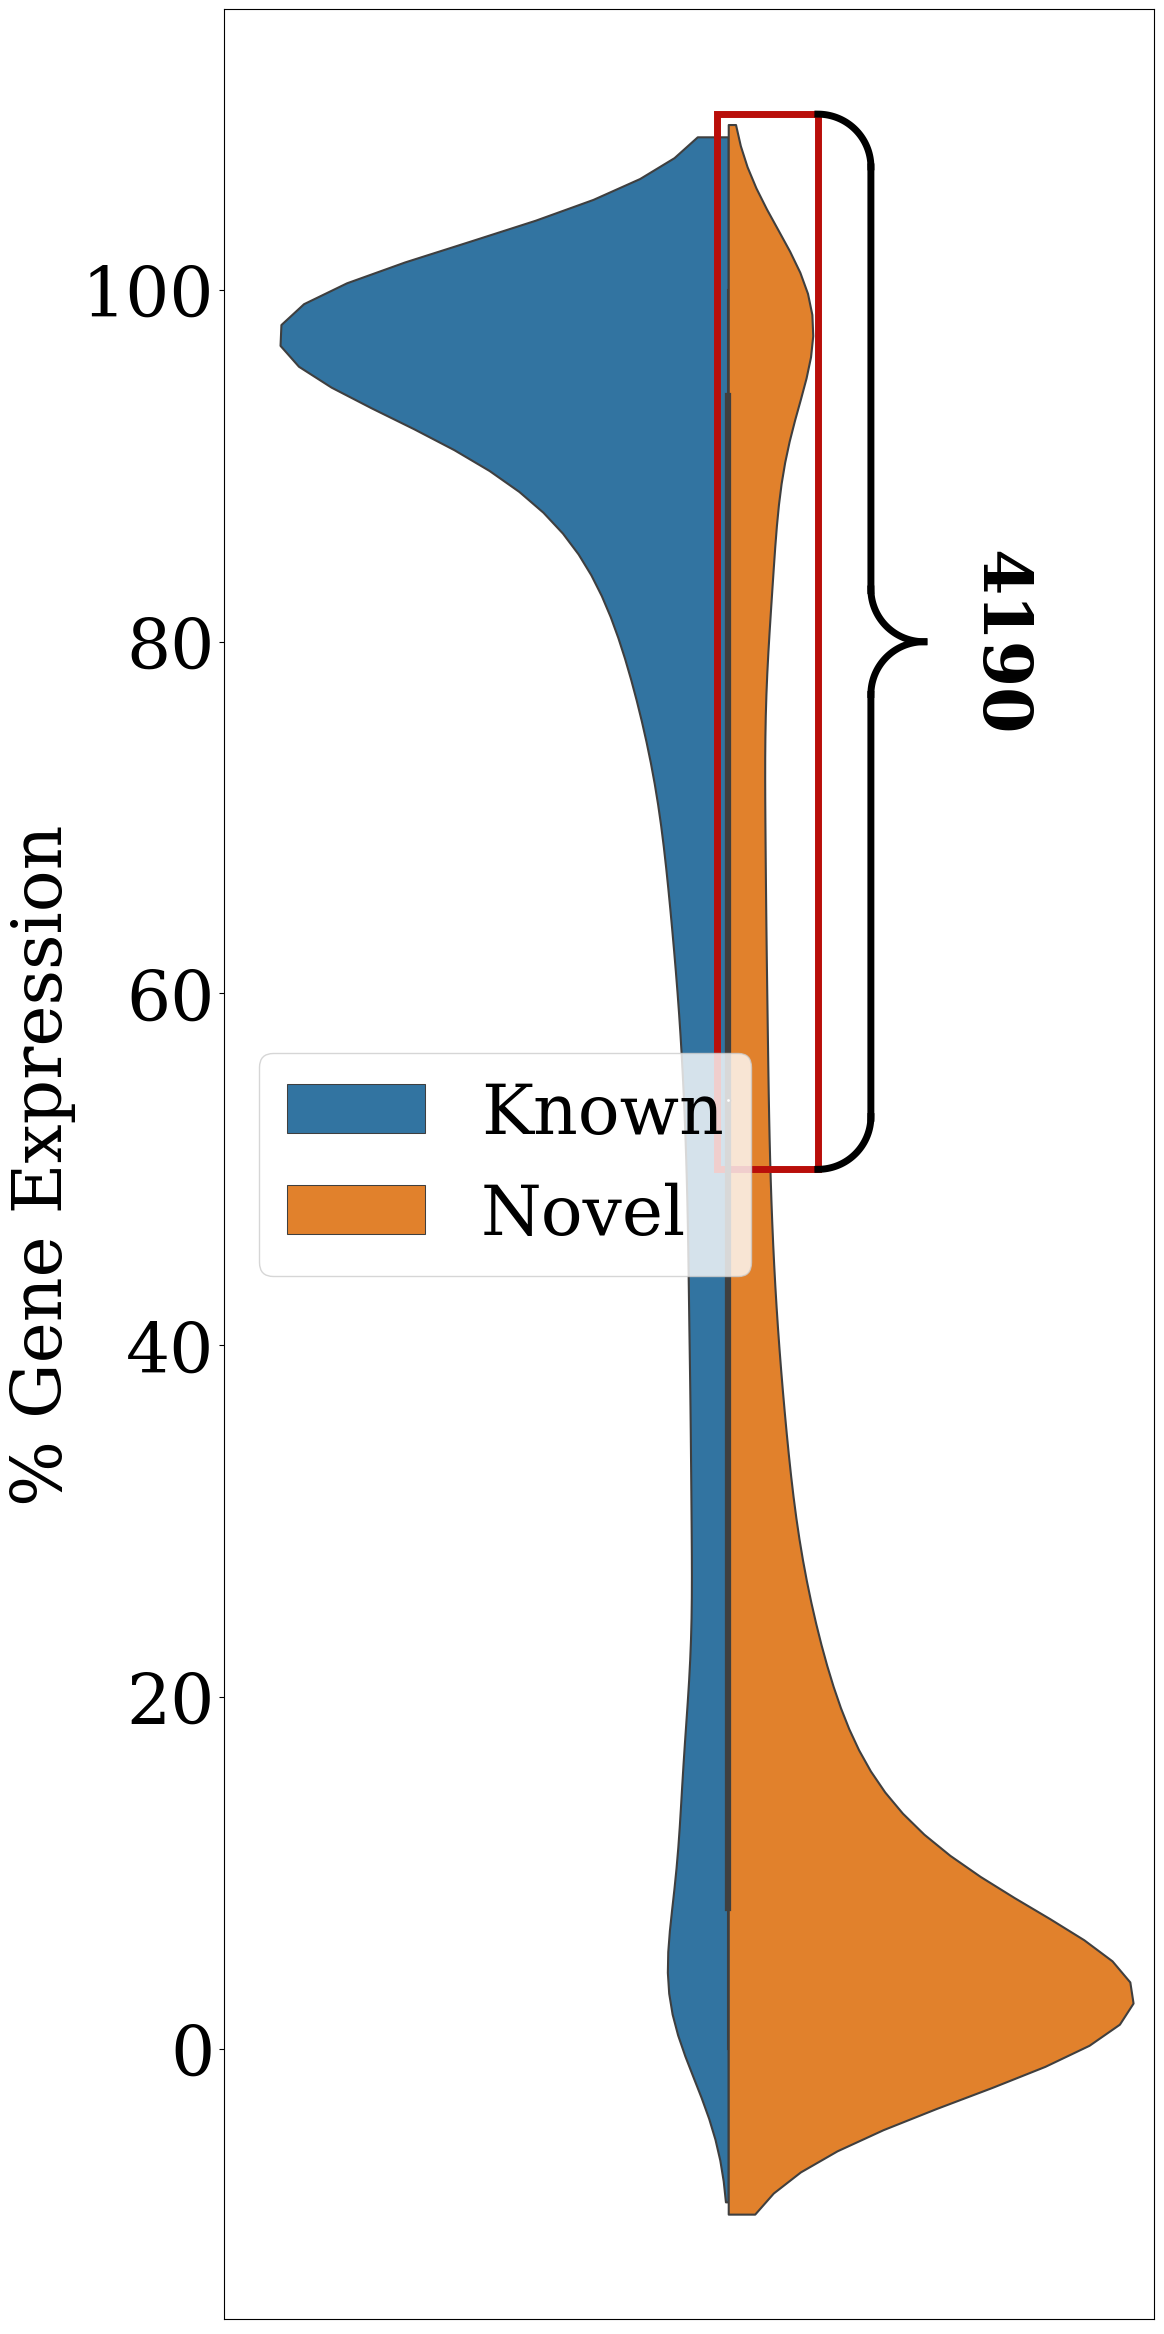

In [54]:
# plt.rcParams['figure.figsize'] = (12.0, 28.0)
params = {'figure.figsize': (12,30),
          'legend.fontsize': 50,
          'axes.labelsize': 50,
          'axes.titlesize': 50,
          'xtick.labelsize': 50,
          'ytick.labelsize': 50,
          'font.size': 50}
pylab.rcParams.update(params)

sns.violinplot(x="all",y="perc",hue="ORF Type",data=psod.rename({"known":"ORF Type"},axis=1).replace({"ORF Type":{1:"Known",0:"Novel"}}), split=True)
f1 = plt.gcf()
plt.ylabel("% Gene Expression")
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
plt.legend(loc=6)
xlims = ax.get_xlim()
print(xlims)
ax.set_xlim(-0.45,0.38)

axins_psod = psod[(psod["known"]==0)&(psod["perc"]>=50)].reset_index(drop=True)
print(len(axins_psod))

# sub region of the original image
x1, x2, y1, y2 = -0.01, 0.08, 50, 110

plt.xticks(visible=False)
rect = patches.Rectangle((-0.01,50), 0.09, 60, linewidth=5,color="#B90E0A", fc="none")

# Add the patch to the Axes
ax.add_patch(rect)


# curly bracket 1 start point and end point
p1 = [0.08,50]
p2 = [0.08,110]

# fontdict for curly bracket 1 text
font = {'family': 'serif',
        'color':  'k',
        'weight': 'bold',
        'size': 48,
        }

# coefficient for curly bracket 1
k_r1 = 0.05

# clockwise, need to swap the start point and end point
curlyBrace(f1, ax, p2, p1, k_r1, bool_auto=True, str_text=str(len(axins_psod)), color='black', lw=5, int_line_num=2, fontdict=font)


plt.savefig(outdir+"gene_expr_perc.svg")
print(outdir+"gene_expr_perc.svg")

In [47]:
psod = sod[["mane_tid","known","sum_tpm"]].groupby(by=["mane_tid","known"]).sum().reset_index()
psod = psod.merge(sod[["mane_tid","sum_tpm"]].groupby(by="mane_tid").sum().reset_index(),on="mane_tid",how="left")
psod.columns = ["mane_tid","known","sum_tpm","gene_tpm"]
psod["all"] = "x"
psod["perc"] = psod["sum_tpm"]/psod["gene_tpm"]
psod.sort_values(by=["perc","gene_tpm"],ascending=False,inplace=True)
psod.head()

gsod = sod[sod["has_cds"]==1][["mane_tid","known","chain_str","sum_tpm"]].groupby(by=["mane_tid","known","chain_str"]).sum().reset_index()
gsod = gsod.merge(sod[["mane_tid","sum_tpm"]].groupby(by="mane_tid").sum().reset_index(),on="mane_tid",how="left")
gsod.columns = ["mane_tid","known","chain_str","sum_tpm","gene_tpm"]
gsod["all"] = "x"
gsod["perc"] = gsod["sum_tpm"]/gsod["gene_tpm"]
gsod.sort_values(by=["perc","gene_tpm"],ascending=False,inplace=True)
gsod = gsod.merge(mane_gene_names, on="mane_tid",how="left")
gsod.head()

,mane_tid,known,chain_str,sum_tpm,gene_tpm,all,perc,gene_name
0,ENST00000648839.1,1,"chr17-8377564-8377692,8379796-8379936,8382143-...",1.165679e+06,1.165679e+06,x,1.0,RPL26
1,ENST00000372728.4,1,chrX-103062897-103063274,5.155847e+05,5.155847e+05,x,1.0,BEX1
2,ENST00000314133.4,1,"chr11+63974681-63974794,63976225-63976320",4.871259e+05,4.871259e+05,x,1.0,COX8A
3,ENST00000347512.8,1,"chr19+5690508-5690600,5691319-5691453,5691532-...",4.593722e+05,4.593722e+05,x,1.0,RPL36
4,ENST00000382581.5,1,chr4+6640863-6641246,4.303979e+05,4.303979e+05,x,1.0,MRFAP1


In [48]:
# extract gtf corresponding to the selected highly expressed novel orfs
sub_psod = psod[(psod["known"]==0)&(psod["perc"]>=0.85)].reset_index(drop=True)
sub_sod = sod[sod["mane_tid"].isin(sub_psod["mane_tid"])][["tid","mane_tid","has_cds","num_samples","sum_tpm","chain_str","known"]].sort_values(by="sum_tpm")
sub_sod.reset_index(drop=True,inplace=True)
sub_sod.head()

# extract gtf

sub_sod_tids = set(sub_sod["tid"])

with open(outdir+"sub_sod.gtf","w") as outFP:
    with open(out_gtex_refseq_gtf_fname,"r") as inFP:
        for line in inFP:
            lcs = line.split("\t")
            if not len(lcs) == 9:
                continue
            tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
            if tid in sub_sod_tids:
                outFP.write(line)

fpsod = psod[(psod["known"]==0)&(psod["perc"]>=0.85)].sort_values(by="gene_tpm",ascending=False).reset_index(drop=True)
sod_sub = sod[(sod["has_cds"]==1)&\
              (sod["mane_tid"].isin(fpsod["mane_tid"]))].reset_index(drop=True)

gene_names = dict()

mane_lines = dict()
fpsod_mane_tids = set(fpsod["mane_tid"])
with open(mane_gtf_fname,"r") as inFP:
    for line in inFP:
        lcs = line.split("\t")
        if not len(lcs) == 9:
            continue
        tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
        if tid in fpsod_mane_tids:
            gene_name = lcs[8].split("gene_name \"", 1)[1].split("\"", 1)[0]
            gene_names[tid] = gene_name
            
            mane_lines.setdefault(tid,"")
            mane_lines[tid]+=line

known_lines = dict()
sod_known = sod_sub[sod_sub["known"]==1][["top_expressed_tid","sum_tpm"]].groupby(by="top_expressed_tid").sum().reset_index()
sod_known_tpms = pd.Series(sod_known.sum_tpm.values,index=sod_known.top_expressed_tid).to_dict()
with open(out_gtex_refseq_gtf_fname,"r") as inFP:
    for line in inFP:
        lcs = line.split("\t")
        if not len(lcs) == 9:
            continue
        tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
        if tid in sod_known_tpms:
            sum_tpm = round(sod_known_tpms[tid])
            newline = "\t".join(lcs[:-1])+"\t"+"transcript_id \"Known: "+tid+" ("+str(sum_tpm)+" TPM)\";\n"
            known_lines.setdefault(tid,"")
            known_lines[tid]+=newline
                    
novel_lines = dict()
sod_novel = sod_sub[(sod_sub["known"]==0)][["top_expressed_tid","sum_tpm"]].groupby(by="top_expressed_tid").sum().reset_index()
sod_novel_tpms = pd.Series(sod_novel.sum_tpm.values,index=sod_novel.top_expressed_tid).to_dict()
with open(out_gtex_refseq_gtf_fname,"r") as inFP:
    for line in inFP:
        lcs = line.split("\t")
        if not len(lcs) == 9:
            continue
        tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
        if tid in sod_novel_tpms:
            sum_tpm = round(sod_novel_tpms[tid])
            newline = "\t".join(lcs[:-1])+"\t"+"transcript_id \"Novel: "+tid+" ("+str(sum_tpm)+" TPM)\";\n"
            novel_lines.setdefault(tid,"")
            novel_lines[tid]+=newline


In [49]:
skipped_mane_tids = set()
written_mane_tids = set()

In [50]:
# for each locus of interest - get a list of transcripts to plot

with open(outdir+"top_with_orf.gtf","w+") as outFP:
    for idx,row in fgsod.iterrows():
        mane_tid = row["mane_tid"]
        written_mane_tids.add(mane_tid)
        tmp = sod_sub[(sod_sub["has_cds"]==1)&\
                  (sod_sub["mane_tid"]==mane_tid)].reset_index(drop=True)

        if len(tmp)==0:
            skipped_mane_tids.add(mane_tid)
            continue

        tmp_known = tmp[tmp["known"]==1].reset_index(drop=True) # contains all known transcripts and orfs at the locus
        tmp_novel = tmp[(tmp["known"]==0) &\
                        (tmp["chain_str"]==row["chain_str"])].reset_index(drop=True) #contains the novel transcripts with high expression that correspond to the orf

        known_tids = set(tmp_known["top_expressed_tid"])
        novel_tids = set(tmp_novel["top_expressed_tid"])
        assert len(novel_tids)==1,"multiple novel: "+mane_tid+"\t"+row["chain_str"]

        outFP.write(mane_lines[mane_tid])

        for t in known_tids:
            outFP.write(known_lines[t])

        for t in novel_tids:
            outFP.write(novel_lines[t])